##Midterm 3 - Assignment 2 (Luca Marini)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# load CIFAR10 training and test set with pyhtorch libraries
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # apply normalization
TR = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
TS = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


##Reference:
This tech report (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail:
<br>Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
<br>http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Network Architecture
The Architecture of the Networks is the <b>Slimmed ResNet18</b> defined in the paper "Gradient Episodic Memory for Continual Learning" by Lopez et al.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, avg_pool2d


"""This is the slimmed ResNet as used by Lopez et al. in the GEM paper."""
class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf

        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SlimResNet18(nclasses, nf=20):
    """Slimmed ResNet18."""
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

## Grid search and k-fold Cross validation
To pick the best hyperparameters I performed a <b>grid search</b> over a <b>5-fold cross validation</b> for the <b>learning rate</b> value. To avoid loading too much the grid search, I made some preliminar tests to check wich are the the best dimension of the <b>batches</b> for training and the number of <b>epochs</b> in wich I could get the best accuracy without falling in overfitting. I compared the behaviour for batch size of 16, 32 and 64 and the best turn out to be 16, while for the epochs I discovered that the most convenient number was 6.
<br>
<br>After performing the cross validation I selected the best model which is the one withlearning rate of <b>0.001</b>.
<br>Finally I trained the model performing again a cross validation. I used the <b>Adam Optimization Algorithm</b>, an evolution of classical SGD but it adapts the given learning rate separately for each network parameter. In practice it gave me slightly better performance, but most importantly, in much fewer epochs than classical SGD with momentum.
<br>
<br>As a result of a 5-fold cross validation I obtained 5 different networks, which were then used to create a final <b>ensemble</b>. To obtain the predicion on a certain image I implemented a method that returns the most voted class, and in case of draws in the voting process, the methods return the alternative voted by the network that had a better validation accuracy during the cross validation.

In [12]:
# grid search parameters

# kernel combinations with 3 convolutional layers (never diminish size for deeper layers)
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.1]

In [7]:
from sklearn.model_selection import KFold
import random
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(19)
loss = nn.CrossEntropyLoss() # define the loss

k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=19)

In [8]:
#define operations for training and validation epochs

def train_epoch(model, device, dataloader, loss_fn, optimizer):
  training_loss = 0.0
  training_correct = 0
  model.train() # set the mode for training
  for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad() # set gradient to zero after each mini-batch
    output = model(images)
    loss = loss_fn(output, labels)

    # computer gradient and update it for all parameters
    loss.backward()
    optimizer.step()

    # check correct classifications
    training_loss += loss.item() * images.size(0)
    scores, predictions = torch.max(output.data, 1)
    training_correct += (predictions == labels).sum().item()
  return training_loss, training_correct

def valid_epoch(model, device, dataloader, loss_fn):
  valid_loss = 0.0
  val_correct = 0
  model.eval() # set the mode for validation
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = loss_fn(output, labels)

      # check correct classifications
      valid_loss += loss.item() * images.size(0)
      scores, predictions = torch.max(output.data, 1)
      val_correct += (predictions == labels).sum().item()
  return valid_loss, val_correct

In [18]:
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

# empirically set hyperparameters
best_batch_size = 16
best_num_epochs = 6

#iterate through grid search hyperparameters values
for learning_rate in learning_rates:

  fold_data = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
  for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(TR)))):
    final_TR_loss = 0
    final_VL_loss = 0
    final_TR_acc = 0
    final_VL_acc = 0

    # split the dataset into training and validation set for this fold
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(TR, batch_size=best_batch_size, sampler=train_sampler)
    valid_loader = DataLoader(TR, batch_size=best_batch_size, sampler=valid_sampler)

    # define the model for the current fold of cross validation
    model = SlimResNet18(len(TR.classes))
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(best_num_epochs): # training and validation of the model and measure of the performance
      TR_loss, TR_acc = train_epoch(model, device, train_loader, loss, optimizer)
      VL_loss, VL_acc = valid_epoch(model, device, valid_loader, loss)

      TR_loss = TR_loss / len(train_loader.sampler)
      TR_acc = TR_acc / len(train_loader.sampler) * 100
      VL_loss = VL_loss / len(valid_loader.sampler)
      VL_acc = VL_acc / len(valid_loader.sampler) * 100

      final_TR_loss = TR_loss
      final_VL_loss = VL_loss
      final_TR_acc = TR_acc
      final_VL_acc = VL_acc

    fold_data['train_loss'].append(final_TR_loss)
    fold_data['val_loss'].append(final_VL_loss)
    fold_data['train_acc'].append(final_TR_acc)
    fold_data['val_acc'].append(final_VL_acc)

  # print results
  avg_train_loss = np.mean(fold_data['train_loss'])
  avg_val_loss = np.mean(fold_data['val_loss'])
  avg_train_acc = np.mean(fold_data['train_acc'])
  avg_val_acc = np.mean(fold_data['val_acc'])
  print("Starting learning rate: " + str(learning_rate))
  print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f}".format(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc))
  print()

Starting learning rate: 0.0005
Average Training Loss: 0.3958 	 Average Val Loss: 0.6033 	 Average Training Acc: 86.246 	 Average Val Acc: 79.916

Starting learning rate: 0.001
Average Training Loss: 0.4099 	 Average Val Loss: 0.5960 	 Average Training Acc: 85.664 	 Average Val Acc: 80.240

Starting learning rate: 0.005
Average Training Loss: 0.4198 	 Average Val Loss: 0.6352 	 Average Training Acc: 85.225 	 Average Val Acc: 78.830

Starting learning rate: 0.01
Average Training Loss: 0.4829 	 Average Val Loss: 0.6442 	 Average Training Acc: 83.019 	 Average Val Acc: 78.366

Starting learning rate: 0.1
Average Training Loss: 1.8185 	 Average Val Loss: 1.8020 	 Average Training Acc: 29.498 	 Average Val Acc: 29.720



In [19]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
import bisect

# hyperparameters of the best model
learning_rate = 0.001
batch_size = 16
epochs = 6

ensemble = []
better_performances = []
best_folds = []


history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
fold_data = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(TR)))):
  final_TR_loss = 0
  final_VL_loss = 0
  final_TR_acc = 0
  final_VL_acc = 0

  print('Fold {}'.format(fold + 1))

  # split the dataset into training and validation set for this fold
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(val_idx)
  train_loader = DataLoader(TR, batch_size=batch_size, sampler=train_sampler)
  valid_loader = DataLoader(TR, batch_size=batch_size, sampler=valid_sampler)

  # define the model for the current fold of cross validation
  model = SlimResNet18(len(TR.classes))
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(epochs):  # training and validation of the model and measure of the performance
    TR_loss, TR_correct = train_epoch(model, device, train_loader, loss, optimizer)
    VL_loss, VL_correct = valid_epoch(model, device, valid_loader, loss)

    TR_loss = TR_loss / len(train_loader.sampler)
    TR_acc = TR_correct / len(train_loader.sampler) * 100
    VL_loss = VL_loss / len(valid_loader.sampler)
    VL_acc = VL_correct / len(valid_loader.sampler) * 100

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.2f} % AVG Val Acc {:.2f} %".format(epoch + 1, epochs, TR_loss, VL_loss, TR_acc, VL_acc))

    history['train_loss'].append(TR_loss)
    history['val_loss'].append(VL_loss)
    history['train_acc'].append(TR_acc)
    history['val_acc'].append(VL_acc)
    final_TR_loss = TR_loss
    final_VL_loss = VL_loss
    final_TR_acc = TR_acc
    final_VL_acc = VL_acc

  fold_data['train_loss'].append(final_TR_loss)
  fold_data['val_loss'].append(final_VL_loss)
  fold_data['train_acc'].append(final_TR_acc)
  fold_data['val_acc'].append(final_VL_acc)

  # get a rank of the best folds
  bisect.insort(better_performances, final_VL_acc)
  index = better_performances.index(final_VL_acc)
  best_folds.insert(index, fold)

  ensemble.append(model)

avg_train_loss = np.mean(fold_data['train_loss'])
avg_val_loss = np.mean(fold_data['val_loss'])
avg_train_acc = np.mean(fold_data['train_acc'])
avg_val_acc = np.mean(fold_data['val_acc'])
best_folds.reverse()

# print results
print()
print("batch size: " + str(batch_size) + ", starting learning rate: " + str(learning_rate))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f}".format(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc))

Fold 1
Epoch:1/6 AVG Training Loss:1.415 AVG Val Loss:1.058 AVG Training Acc 48.28 % AVG Val Acc 62.56 %
Epoch:2/6 AVG Training Loss:0.949 AVG Val Loss:0.780 AVG Training Acc 66.69 % AVG Val Acc 72.53 %
Epoch:3/6 AVG Training Loss:0.741 AVG Val Loss:0.669 AVG Training Acc 74.19 % AVG Val Acc 76.35 %
Epoch:4/6 AVG Training Loss:0.610 AVG Val Loss:0.616 AVG Training Acc 78.77 % AVG Val Acc 78.70 %
Epoch:5/6 AVG Training Loss:0.505 AVG Val Loss:0.606 AVG Training Acc 82.43 % AVG Val Acc 79.46 %
Epoch:6/6 AVG Training Loss:0.416 AVG Val Loss:0.586 AVG Training Acc 85.41 % AVG Val Acc 80.12 %
Fold 2
Epoch:1/6 AVG Training Loss:1.389 AVG Val Loss:1.004 AVG Training Acc 49.71 % AVG Val Acc 63.75 %
Epoch:2/6 AVG Training Loss:0.910 AVG Val Loss:0.785 AVG Training Acc 67.93 % AVG Val Acc 71.98 %
Epoch:3/6 AVG Training Loss:0.721 AVG Val Loss:0.692 AVG Training Acc 74.92 % AVG Val Acc 75.49 %
Epoch:4/6 AVG Training Loss:0.600 AVG Val Loss:0.613 AVG Training Acc 79.05 % AVG Val Acc 78.33 %
Epoch:

In [ ]:
from google.colab import files

# save the models (just one time)
for i in range(k):
  model_name = "CNN" + str(i + 1) + ".pth"
  torch.save(ensemble[i].state_dict(), model_name)
  # download file
  files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load the trained models
ensemble = []
for i in range(k):
  net = SlimResNet18(len(TR.classes))
  state_dict = torch.load("CNN" + str(i + 1) + ".pth")
  net.load_state_dict(state_dict)
  ensemble.append(net)

In [25]:
from statistics import mode

def ensemble_predict(ens, images, device):
  predictions = []
  for i in range(len(ens)):
    outputs = ens[i](images)
    _, preds = torch.max(outputs, 1)
    predictions.append(preds)

  # for each image i save the predictions of each network
  prediction_per_image = []
  for j in range(len(images)):
    util = []
    for i in range(len(ens)):
      util.append(predictions[i][j])

    # voting system
    pred1 = mode(util)
    pred2 = mode(util[::-1])
    if pred1 == pred2: prediction_per_image.append(mode(util))
    else:
      # use the rank of best folds to choose in draws
      for f_ind in range(len(best_folds)):
        if predictions[best_folds[f_ind]][j] == pred1 or predictions[best_folds[f_ind]][j] == pred2:
          prediction_per_image.append(predictions[best_folds[f_ind]][j])
          break

  # return a list of prediction
  res_list = []
  for item in prediction_per_image: res_list.append(item.item())
  prediction_tensor = torch.FloatTensor(res_list)
  return prediction_tensor.to(device)

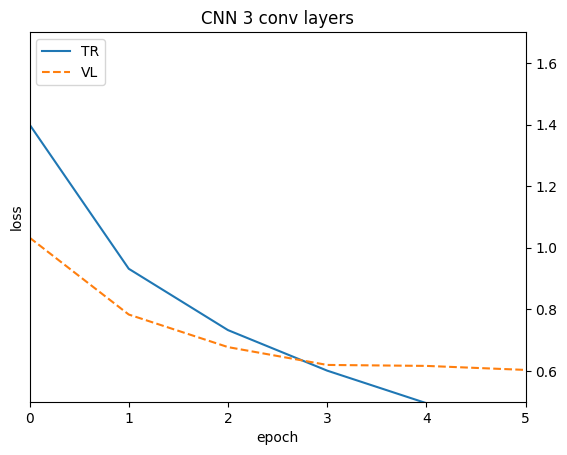

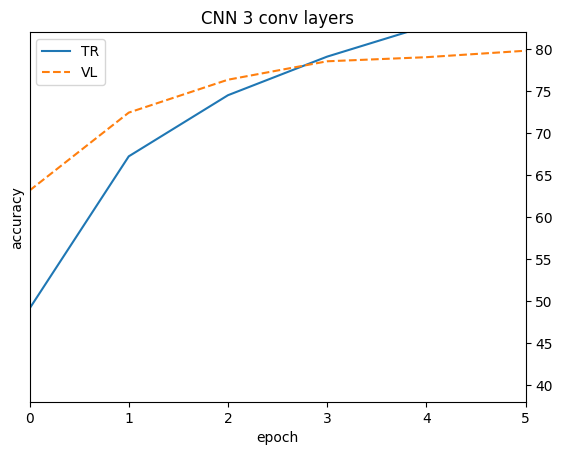

In [21]:
# plot learning curve

# organize data of training loss
train_loss_per_epoch = []
for i in range(epochs):
  util = []
  for j in range(len(history['train_loss'])):
    if j % epochs == i:
      util.append(history['train_loss'][j])
  train_loss_per_epoch.append(np.mean(util))

# organize data of validation loss
val_loss_per_epoch = []
for i in range(epochs):
  util = []
  for j in range(len(history['val_loss'])):
    if j % epochs == i:
      util.append(history['val_loss'][j])
  val_loss_per_epoch.append(np.mean(util))

# organize data of training accuracy
train_acc_per_epoch = []
for i in range(epochs):
  util = []
  for j in range(len(history['train_acc'])):
    if j % epochs == i:
      util.append(history['train_acc'][j])
  train_acc_per_epoch.append(np.mean(util))

# organize data of validation accuracy
val_acc_per_epoch = []
for i in range(epochs):
  util = []
  for j in range(len(history['val_acc'])):
    if j % epochs == i:
      util.append(history['val_acc'][j])
  val_acc_per_epoch.append(np.mean(util))

# plot loss graph
plot = plt.figure()
ax = plot.add_subplot(111)
ax.yaxis.tick_right()
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch, linestyle="dashed")
plt.axis([0, epochs - 1, 0.5, 1.7])
plt.title('CNN 3 conv layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TR', 'VL'], loc='upper left')
plt.show()

# plot accuracy graph
plot = plt.figure()
ax = plot.add_subplot(111)
ax.yaxis.tick_right()
plt.plot(train_acc_per_epoch)
plt.plot(val_acc_per_epoch, linestyle="dashed")
plt.axis([0, epochs - 1, 38, 82])
plt.title('CNN 3 conv layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TR', 'VL'], loc='upper left')
plt.show()

## Test
Finally, I tested the network on the test set to check its generalization capabilities.
<br>I also calculate the accuracy for each class of the test set images.

In [31]:
correct = 0
total = 0

batch_loader = 5
loader_test = torch.utils.data.DataLoader(TS, batch_size=batch_loader, shuffle=False, num_workers=2)

# make prediction over all the images and calculate accuracy
with torch.no_grad():
  for data in loader_test:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    predictions = ensemble_predict(ensemble, images, device)

    total += labels.size(0)
    correct += (predictions == labels).sum().item()

print("Accuracy of the network on the 10000 test images: " + str(100 * correct / total) + " %")

Accuracy of the network on the 10000 test images: 80.2 %


In [33]:
correct_pred = [0] * len(classes)
total_pred = [0] * len(classes)

# make prediction over all the images and calculate accuracy for each class of images
with torch.no_grad():
  for data in loader_test:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    predictions = ensemble_predict(ensemble, images, device)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[label] += 1
      total_pred[label] += 1


# print accuracy for each class
for i in range(len(correct_pred)):
  accuracy = 100 * float(correct_pred[i]) / total_pred[i]
  print(f'Accuracy for class: {classes[i]:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 89.0 %
Accuracy for class: car   is 95.3 %
Accuracy for class: bird  is 63.7 %
Accuracy for class: cat   is 60.6 %
Accuracy for class: deer  is 75.6 %
Accuracy for class: dog   is 72.9 %
Accuracy for class: frog  is 88.9 %
Accuracy for class: horse is 84.9 %
Accuracy for class: ship  is 90.7 %
Accuracy for class: truck is 80.4 %


## Occlusion experiment
After training and collecting the results of the network I proceeded to the <b>occlusion experiment</b>. I take 2 images of each class that were correctly classified by the network and then I apply the occlusions on them, after that I ask the network to classify the resulting occlusions and for each image I calculated the percentage of the correct classified versions of the occluded image. The experiment was made for <b>8x8</b> and <b>4x4</b> occlusions.
<br>After that I show an example both for 4x4 and 8x8 occlusions. For 8x8 it's shown a grid with the occlusion performed on a certain image and the response of the network for each of them; for 4x4 instead, it's shown only an occlusion of a certain image (the only one, for that image, in wich the network had a miscalssification) and the response of the network.

In [42]:
images = []
labels = []

TS_loader_experiment = torch.utils.data.DataLoader(TS, batch_size=1, shuffle=False, num_workers=2)

# save all the images and their relative class
with torch.no_grad():
  for data in TS_loader_experiment:
    imgs, lbls = data
    images.append(imgs.to(device))
    labels.append(lbls.to(device))

In [43]:
occlusion_experiment_images = []
occlusion_experiment_labels = []

#take 2 well classified images per class
for c in range(len(classes)):
  found = 0
  i = 0
  while found < 2 and i < len(images):
    if(labels[i] == c):
      predicted = ensemble_predict(ensemble, images[i], device)
      if(predicted == labels[i]):
        occlusion_experiment_images.append(images[i])
        occlusion_experiment_labels.append(labels[i])
        found += 1
    i += 1

In [44]:
import copy

# given some images performs NxN occlusion all over each image
def get_occluded_images(N, clean_images):
  image_occluded_replicas = []
  # create occluded images (NxN occlusions)
  for image in clean_images:
    image_occlusion_list = []
    for slide_x in range(0, len(image[0][0]), N):
      for slide_y in range(0, len(image[0][0][0]), N):
        clean_image = copy.deepcopy(image)
        for layer in clean_image[0]:
          for i in range(len(layer)):
            if i < N:
              for j in range(len(layer[i])):
                if j < N:
                  layer[i + slide_x][j + slide_y] = 0 # set pixel to grey
        image_occlusion_list.append(clean_image)
    image_occluded_replicas.append(image_occlusion_list)
  return image_occluded_replicas

In [46]:
# print performance of the network for each occluded image
def check_occlusions_results(image_dim, occlusion_dim, occluded_images, labels):
  occlusion_per_image = int((image_dim * image_dim) / (occlusion_dim * occlusion_dim))
  for i in range(len(occluded_images)):
    correct = 0
    for occlusion in occluded_images[i]:
      predicted = ensemble_predict(ensemble, occlusion, device)
      if predicted == labels[i]:
        correct += 1
    print("Correct occlusion classification for image " + str(i) + ": " + str(correct) + "/" + str(occlusion_per_image) + " ->\t" + str(correct * 100 / occlusion_per_image) + "%")

In [47]:
# results on 8x8 occlusions
image_occluded_replicas = get_occluded_images(8, occlusion_experiment_images)
check_occlusions_results(len(images[0][0][0]), 8, image_occluded_replicas, occlusion_experiment_labels)

Correct occlusion classification for image 0: 16/16 ->	100.0%
Correct occlusion classification for image 1: 16/16 ->	100.0%
Correct occlusion classification for image 2: 13/16 ->	81.25%
Correct occlusion classification for image 3: 14/16 ->	87.5%
Correct occlusion classification for image 4: 7/16 ->	43.75%
Correct occlusion classification for image 5: 16/16 ->	100.0%
Correct occlusion classification for image 6: 16/16 ->	100.0%
Correct occlusion classification for image 7: 16/16 ->	100.0%
Correct occlusion classification for image 8: 11/16 ->	68.75%
Correct occlusion classification for image 9: 16/16 ->	100.0%
Correct occlusion classification for image 10: 9/16 ->	56.25%
Correct occlusion classification for image 11: 16/16 ->	100.0%
Correct occlusion classification for image 12: 16/16 ->	100.0%
Correct occlusion classification for image 13: 16/16 ->	100.0%
Correct occlusion classification for image 14: 16/16 ->	100.0%
Correct occlusion classification for image 15: 15/16 ->	93.75%
Corre

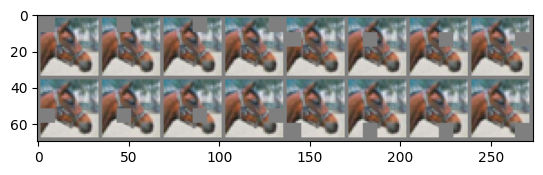

[['horse', 'horse', 'horse', 'horse', 'truck', 'horse', 'horse', 'horse'],
 ['horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse']]

In [51]:
subset = []
classifications = []

# show an example of how the network behaves on different occlusion in the same image

for i in range(int((len(images[0][0][0]) * len(images[0][0][0])) / (8 * 8))):
  subset.append(image_occluded_replicas[15][i][0].to("cpu"))
  classifications.append(classes[int(ensemble_predict(ensemble, image_occluded_replicas[15][i], device))])
classifications = [classifications[0:8], classifications[8:16]]

imshow(torchvision.utils.make_grid(subset))
classifications

In [52]:
# results on 4x4 occlusions
image_occluded_replicas = get_occluded_images(4, occlusion_experiment_images)
check_occlusions_results(len(images[0][0][0]), 4, image_occluded_replicas, occlusion_experiment_labels)

Correct occlusion classification for image 0: 64/64 ->	100.0%
Correct occlusion classification for image 1: 64/64 ->	100.0%
Correct occlusion classification for image 2: 58/64 ->	90.625%
Correct occlusion classification for image 3: 63/64 ->	98.4375%
Correct occlusion classification for image 4: 32/64 ->	50.0%
Correct occlusion classification for image 5: 64/64 ->	100.0%
Correct occlusion classification for image 6: 64/64 ->	100.0%
Correct occlusion classification for image 7: 64/64 ->	100.0%
Correct occlusion classification for image 8: 63/64 ->	98.4375%
Correct occlusion classification for image 9: 64/64 ->	100.0%
Correct occlusion classification for image 10: 49/64 ->	76.5625%
Correct occlusion classification for image 11: 64/64 ->	100.0%
Correct occlusion classification for image 12: 64/64 ->	100.0%
Correct occlusion classification for image 13: 64/64 ->	100.0%
Correct occlusion classification for image 14: 64/64 ->	100.0%
Correct occlusion classification for image 15: 64/64 ->	100

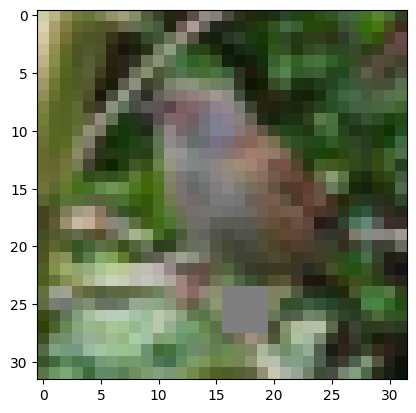

'frog'

In [64]:
subset = []
classifications = []

# show an example from a certain image of the only occlusion that fooled the network

for i in range(int((len(images[0][0][0]) * len(images[0][0][0])) / (4 * 4))):
  subset.append(image_occluded_replicas[4][i][0].to("cpu"))
  classifications.append(classes[int(ensemble_predict(ensemble, image_occluded_replicas[4][i], device))])

imshow(torchvision.utils.make_grid(subset[52]))
classifications[52]

## Results and final considerations
The performance of the network are the following:


*   Average accuracy on TR: 85.752%
*   Average accuracy on VL: 79.784%
*   Accuracy on TS: 80.2%

From the results from each class of TS images, we can notice that the network works good for most of the classes (in particular car, frog, ship and plane), but has quite poor results for birds and cats.
<br>
<br>About the experiment, we can see, as expected, that bigger occlusions couse more problems to the network; in fact, we have better overall performance on 4x4 than on 8x8. Another thing that can be noticed in the overall is that there are certain images that gives more issues than others for both dimensions, in particular image 4 and 10.
<br>In general, one can observe that the position of the patch and the low resolution of the images are some of the most influent things that can lead to a misclassification.
<br>
<br>At the end, I can say that although the accuracy of the network could be increased with some advanced techniques, the results I get are coherent with what can be expected, both from the problem itself and the occlusion experiment.